# Gender Classification on Reddit
\__author__ = Jonathan Hourany

\__email__  = Jon.Hourany@gmail.com

<div style="text-align:left">
    <img src='images/male-clipart.png' style="width: 80px; float:left">
</div>
<div style="text-align:right">
    <img src='images/female-clipart.png' style="width: 100px; float:right">
</div>
<div style="text-align:middle">
    <img src='images/snoo.png' style="width: 200px; float:center">
</div>

### Why this project?
* Data used to profile
* Psychological observational studies
* How anonymous is anonymous?

# The Data
* Gender tagged data not available in the wild
* Had to scrape from volunteered data

!['progresspics'](images/progresspics.png)

### The Python Reddit API Wrapper
* Python package that allows for simple access to reddit's API
* get_subreddit, get_hot(), get_redditor()
* __Handled Requests Limit__

### Redditor Class


In [1]:
import re
import praw
import pandas as pd
from string import punctuation


class Redditor:
    def __init__(self, username, sex, age=None, comments={}, subreddits=set()):
        self.username = username
        self.sex = sex
        self.age = age
        self.comments = comments
        self.subreddits = subreddits

    @classmethod
    def from_post_title(cls, submission_obj, reddit_session, comment_limit=200):
        '''Automatically contruct a redditor from a post link

        Parameters
        -----------
        cls             A class object
        submission_obj: PRAW Submission Object
        reddit_session: Instance of a PRAW Reddit Session 

        Returns
        -------
        redditor:   Instance of Redditor
        '''
        sex, age, *_ = submission_obj.title.lower().split('/')
        age = int(age)
        username = submission_obj.author
        redditor = cls(username, sex, age)
        try:
            r = reddit_session.get_redditor(username)
        except:
            pass
        comments_obj = r.get_comments(limit=comment_limit)
        redditor.subreddits, redditor.comments = redditor.process_comment(comments_obj)
        return redditor

    @classmethod
    def from_flair(cls, submission_obj, reddit_session):
        pass

    @staticmethod
    def process_comment(comments_obj):
        '''Parses a comments_obj for relavent data

        Parameters
        -----------
        comments_obj: PRAW Comment Object

        Returns
        -------
        subreddits: list,
            A list of strings containing subreddits comments were made in

        comments: tuple, (comment_id, string)
            A tuple of comments and their reddit designated ids
        '''
        comments = []
        subreddits = []
        for comment in comments_obj:
            subreddits.append(comment.subreddit.display_name)
            comments.append((comment.fullname, comment.body.strip()))
        return subreddits, comments

    @staticmethod
    def process_text(self, comment):
        comment = self._clean_text(comment)
        return comment.lower()

    @staticmethod
    def _clean_text(self, text, pattern):
        allowable = (':', ')', '(')           # Punctuation marks used in emoticons
        punctuation  = '[' + ''.join([ch for ch in punctuation if ch not in allowable]) + ']'
        emoticon_pat = '(?<!\:)\)|(?<!\:)\('  # Don't pick up common emoticons
        special_pat  = '[\n]'
        markup_link  = '\[\w+\]|\(http.*\)'   # Markup syntax for hyperlinks
        pattern = "|".join((emoticon_pat, markup_link, special_pat, punctuation))
        text = re.sub(pattern, '', text)
        return text.strip()

    @property
    def username(self):
        '''Getter for username attribute'''
        return self._username

    @username.setter
    def username(self, username):
        '''Setter for username attribute. 

        Parameters
        ----------
        username: str

        Exceptions
        -----------
        Raises ValueError if parameters do not match reddit's restriction on usernames
        '''
        if not re.search('[a-zA-Z0-9\_\-]', str(username)):
            raise ValueError('{username} is not a valid reddit username'.format(username))
        self._username = str(username).lower()

    @property
    def sex(self):
        '''Getter for sex attribute'''
        return self._sex

    @sex.setter
    def sex(self, sex):
        '''Setter for sex attribute

        Parameters
        ----------
        sex: str

        Exceptions
        -----------
        Raises ValueError if parameters are not m or f
        '''
        sex = sex.lower()
        if sex not in ('m', 'f'):
            raise ValueError("Sex can only be 'm' or 'f'")
        gender = {'m': 0, 'f': 1}
        self._sex = gender[sex]

    @property
    def subreddits(self):
        '''Getter for subbreddits attribute'''
        return self._subreddits

    @subreddits.setter
    def subreddits(self, subreddits):
        '''Setter for subreddits attribute. Stores values as set()

        Parameters
        ----------
        subreddits: list
        '''
        self._subreddits = set(subreddit.lower() for subreddit in subreddits)

    @property
    def comments(self):
        '''Getter for comments attribute'''
        return self._comments

    @comments.setter
    def comments(self, comments):
        self._comments = dict(comments)

    def __str__(self):
        return self.username

    def __len__(self):
        return len(self.comments)

### Main()

In [2]:
def main():
    # Messages to report changes in major phases
    start_msg    = '\n---- Reddit Mining Started ----\n'
    mining_msg   = '- Mining subreddits for posts'
    parse_msg    = '- Parsing data...'
    writeout_msg = '- Writting data to CSV file'
    user_agent   = 'NLP Webscrapper 0.4'

    # DataFrame columns
    df_user_columns = ['uid', 'Username', 'Sex', 'Age']
    df_comment_columns = ['uid', 'Comment_id', 'Comment']
    df_subreddits_columns = ['uid', 'Subreddit']

    # List of user features to map to dict
    user_features = ['Username', 'Sex', 'Age']

    # List of subreddits to data mine
    mineable_subreddits = ['progresspics']

    # Location of database tables
    users_tbl_path = 'test/users_df.csv'
    comments_tbl_path = 'test/comments_df.csv'
    subreddits_tbl_path = 'test/subreddits_df.csv'

    redditors = []
    db_exists = False
    count = 0   # Tracks count of posts processed. Purely for print outs.

    try:
        # Assume these tables already exsist and load them.
        users_df = pd.read_csv(users_tbl_path)
        comments_df = pd.read_csv(comments_tbl_path)
        subreddits_df = pd.read_csv(subreddits_tbl_path)
        user_id = users_df['uid'].max()
        db_exists = True
        # We don't want to get users we've already seen
        collected_users = set(users_df['Username'])
    except IOError:
        # Raised if the tables don't exsist, so start the UID at somewhere
        user_id = 100
        collected_users = set()

    # Init and connect with Reddit API, start program
    reddit = praw.Reddit(user_agent=user_agent)
    print(start_msg)
    print(mining_msg)

    for subreddit in mineable_subreddits:
        print(' ~ Mining Subreddit: {}'.format(subreddit))
        posts = reddit.get_subreddit(subreddit)
        for submission in posts.get_hot(limit=400):
            try:
                redditor = Redditor.from_post_title(submission, reddit, comment_limit=200)
                if redditor.username not in collected_users:
                    redditors.append(redditor)
            except (AttributeError, ValueError):
                # Value errors raised by the Redditor Class going to be because of
                #  links that don't have the correct formatting (e.g. sticky posts)
                #  or when the user has made no comments. When these occur,
                #  its fine to just drop the submission
                pass
            except:
                # For all other exceptions, break out of the loop and attempt
                #  to save what data has ben collected
                break
            print('  ~ Processing User -- # {0}: '.format(count))
            count += 1

    # When Mining is complete, save data to appropriate files
    print(parse_msg)

    # Data is saved in Dict's and passed to pandas DataFrame. Keys
    # represent column headers in the DataFrame/CSV file
    user_dict = {'uid': []}
    comments_dict = {'uid': [], 'Comment_id': [], 'Comment': []}
    subreddits_dict = {'uid': [], 'Subreddit': []}
    for redditor in redditors:
        user_id += 1
        comments_dict['Comment_id'].extend(list(redditor.comments.keys()))
        comments_dict['Comment'].extend(list(redditor.comments.values()))
        comments_dict['uid'].extend([user_id] * len(redditor.comments))
        user_dict['uid'].append(user_id)
        subreddits_dict['uid'].extend([user_id] * len(redditor.subreddits))
        subreddits_dict['Subreddit'].extend(list(redditor.subreddits))
        for feature in user_features:
            user_dict.setdefault(feature, []).append(redditor.__getattribute__(feature.lower()))

    print(writeout_msg)

    if not db_exists:
        user_tbl = pd.DataFrame(user_dict, columns=df_user_columns)
        comments_tbl = pd.DataFrame(comments_dict, columns=df_comment_columns)
        subreddits_tbl = pd.DataFrame(subreddits_dict, columns=df_subreddits_columns)
    else:
        user_tbl = users_df.append(pd.DataFrame(user_dict,
                                   columns=df_user_columns))
        comments_tbl = comments_df.append(pd.DataFrame(comments_dict,
                                          columns=df_comment_columns))
        subreddits_tbl = subreddits_df.append(pd.DataFrame(subreddits_dict,
                                              columns=df_subreddits_columns))

    user_tbl.to_csv(users_tbl_path, index=False)
    comments_tbl.to_csv(comments_tbl_path, index=False)
    subreddits_tbl.to_csv(subreddits_tbl_path, index=False)

if __name__ == '__main__':
    main()


Version 3.4.0 of praw is outdated. Version 3.5.0 was released Tuesday May 10, 2016.

---- Reddit Mining Started ----

- Mining subreddits for posts
 ~ Mining Subreddit: progresspics
  ~ Processing User -- # 0: 
  ~ Processing User -- # 1: 
  ~ Processing User -- # 2: 


/home/protonova/anaconda2/envs/py3_nlp/lib/python3.5/site-packages/ipykernel/__main__.py:65: ResourceWarning: unclosed <ssl.SSLSocket fd=49, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.3.16.107', 59920), raddr=('198.41.209.143', 443)>


- Parsing data...
- Writting data to CSV file


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cleaner import clean_text
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn import cross_validation
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

/home/protonova/anaconda2/envs/py3_nlp/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)
/home/protonova/anaconda2/envs/py3_nlp/lib/python3.5/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/protonova/anaconda2/envs/py3_nlp/lib/python3.5/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/protonova/anaconda2/envs/py3_nlp/lib/python3.5/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the 

In [3]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
users_tbl_path = 'test/users_df.csv'
comments_tbl_path = 'test/cleaned_comments_df_new_stop.csv'
subreddits_tbl_path = 'test/subreddits_df.csv'

In [27]:
user_df = pd.read_csv(users_tbl_path)
comments_df = pd.read_csv(comments_tbl_path)

In [28]:
df = pd.merge(user_df, comments_df, right_on='uid', left_on='uid')

In [29]:
df

,Age,Sex,Username,uid,Comment,Comment_id
0,22,1,kristenly,101,straight woman definitely find attractive,t1_czzdmn8
1,22,1,kristenly,101,know got either work work coffee shop somethin...,t1_cq35l2q
2,22,1,kristenly,101,awesome grandmother struggled weight whole lif...,t1_d1w919g
3,22,1,kristenly,101,pm ed,t1_cqtzv8a
4,22,1,kristenly,101,precisely feel gone insane days,t1_d1wlyfs
5,22,1,kristenly,101,undertoes divine,t1_cxax2b9
6,22,1,kristenly,101,pm guys reddit rules witch hunting,t1_cqu3p28
7,22,1,kristenly,101,know article recent 2 months prompted little b...,t1_coxwwlb
8,22,1,kristenly,101,presidential joke seems pretty accurate well e...,t1_cytnblu
9,22,1,kristenly,101,thank much,t1_d2tvypv


In [20]:
user_df['Sex'].value_counts()

0    324
1    289
Name: Sex, dtype: int64

In [62]:
# TEST BOX
from collections import Counter
#print(comments_df.head())
m = []
f = []
df.dropna(inplace=True)
#[val for sublist in list_of_lists for val in sublist]
sents = df[df['Sex'] == 0]['Comment'].tolist()
m.extend(sent.split() for sent in sents)
m = [val for sublist in m for val in sublist]
male = Counter(m)
print(male.most_common()[:20])

sents = df[df['Sex'] == 1]['Comment'].tolist()
f.extend(sent.split() for sent in sents)
f = [val for sublist in f for val in sublist]
female = Counter(f)
print()
print(female.most_common()[:20])

common1 = [word[0] for word in [f for f in female.most_common()[:20]]]
common2 = [word[0] for word in [m for m in male.most_common()[:20]]]
print()
print([word for word in common1 if word in common2])

print()
print(len(male))
print(len(female))

[('good', 2481), ('really', 2437), ('people', 2301), ('think', 2163), ('much', 2162), ('know', 1988), ('day', 1957), ('also', 1806), ('see', 1683), ('thanks', 1657), ('well', 1575), ('2', 1559), ('work', 1558), ('still', 1554), ('make', 1550), ('got', 1543), ('back', 1537), ('even', 1497), ('way', 1470), ('want', 1456)]

[('really', 3698), ('much', 2970), ('think', 2857), ('good', 2724), ('know', 2709), ('thank', 2586), ('weight', 2537), ('day', 2498), ('also', 2412), ('people', 2408), ('make', 1935), ('want', 1909), ('feel', 1909), ('got', 1886), ('see', 1857), ('even', 1856), ('love', 1855), ('still', 1853), ('work', 1847), ('well', 1756)]

['really', 'much', 'think', 'good', 'know', 'day', 'also', 'people', 'make', 'want', 'got', 'see', 'even', 'still', 'work', 'well']

40944
33302


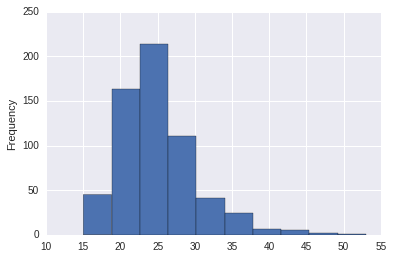

In [52]:
user_df['Age'].plot(kind='hist');

In [11]:
df.dropna(inplace=True)

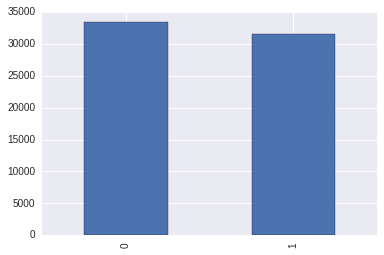

In [12]:
df['Sex'].value_counts().plot(kind='bar');

In [53]:
X_train, X_test, y_train, y_test = \
                cross_validation.train_test_split(df['Comment'],
                                                  df['Sex'],
                                                  test_size =.3)

In [27]:
nb_pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

parameters = {
    'vect__max_features': (None, 10000, 50000),
    'vect__ngram_range': [(1, 4)],
    'tfidf__use_idf': [True],
    'tfidf__smooth_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.5, 0.4, 0.3, 0.2),
    'clf__fit_prior': (True, False)
}

grid_search = GridSearchCV(nb_pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  7.9min finished


Best score: 0.680
Best parameters set:
	clf__alpha: 0.5
	clf__fit_prior: True
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__use_idf: True
	vect__max_features: 50000
	vect__ngram_range: (1, 4)


### Survey says...

In [54]:
nb_pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1,4))),
        ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True)),
        ('clf', MultinomialNB(alpha=0.2, fit_prior=True, class_prior=[0.528, 0.472])),
    ])

nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        strip...alse, use_idf=True)), ('clf', MultinomialNB(alpha=0.2, class_prior=[0.528, 0.472], fit_prior=True))])

Accuracy       0.69
Confusion matrix, without normalization
[[7046 3265]
 [2860 6545]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.3   0.7 ]]


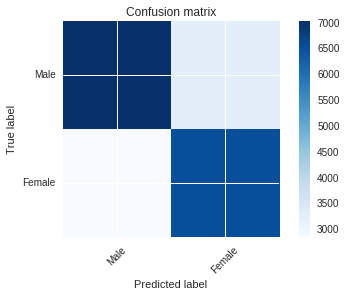

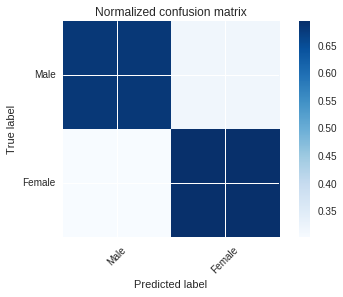

In [55]:
print("Accuracy {0:10.2f}".format(nb_pipeline.score(X_test, y_test)))

# Compute confusion matrix
cm = confusion_matrix(y_test, nb_pipeline.predict(X_test))
np.set_printoptions(precision=2)
target_names = ['Male', 'Female']
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, target_names)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, target_names, title='Normalized confusion matrix')

plt.show()

In [56]:
X_test[nb_pipeline.predict(X_test) != y_test]

54945                              sounds great wee scheme
8620     previously mentioned definitely sounds swinger...
45810                                              perfect
2763     bet pricing ridiculous pack 20 prenatals costs...
33684    hey awesome thing self future body look awesom...
10950    started training around 6 month mark training ...
52757                                            oklahomie
51161                   cosplay flounder animal house spot
12125               afraid people matter high school trust
48286    difference sticky rice mushy rice though still...
50077    honestly kind comes lot us mean lot us everywh...
1063     originally hat pointy looked kkk cat glad came...
34923            ry legit easter egg minimix heeeaaavvvyyy
47102    outgoing comfortable someone yeah generally sp...
18240    thanks know right currently giving stink eye w...
7709     know someone every try nice realized care want...
19769                                                  y

In [57]:
min_str_mask = (df['Comment'].str.len() > 30)
print(len(df))
print(len(df.loc[min_str_mask]))

65719
44058


In [58]:
df.loc[min_str_mask, 'Comment']

0                straight woman definitely find attractive
1        know got either work work coffee shop somethin...
2        awesome grandmother struggled weight whole lif...
4                          precisely feel gone insane days
6                       pm guys reddit rules witch hunting
7        know article recent 2 months prompted little b...
8        presidential joke seems pretty accurate well e...
10       ugh hate type girl stop playing games could ne...
11       wow yeah thanks lot definitely contact never h...
12       op clever many people itt including awesome co...
13                   definitely trying need recipes greens
18       cuteness overload use three sit still look pho...
19       live parents horse race overwhelmingly upset f...
20       think default 2 believe revised recent recipe ...
21       issue build pillows side bed bed feel big also...
22       glad think way visit someone profile though he...
23       something still struggle terrible nc thing 5 d.

In [59]:
X_train, X_test, y_train, y_test = \
                cross_validation.train_test_split(df.loc[min_str_mask, 'Comment'], 
                                                  df.loc[min_str_mask, 'Sex'], 
                                                  test_size =.3) #, idx1, idx2

In [60]:
nb_pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1,4))),
        ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True)),
        ('clf', MultinomialNB(alpha=0.2, fit_prior=True)),
    ])
nb_pipeline.fit(X_train, y_train)
print("Accuracy {0:.2f} ".format(nb_pipeline.score(X_test, y_test)))

Accuracy 0.70 


### Predicting Gender on a single comment

In [29]:
post = "Clevelander here - Mohican State Park is about 1.5 hr drive and is decent, but Hocking Hills is a 3 hr drive and is amazing. My husband and I camped in Mohican last weekend and had a nice time, it wasn't quite as remote as we would've liked, though. If you haven't been to Hocking Hills, that is my #1 recommendation! It's the only place I've visited on this side of the country that feels like being out west. The natural rock formations are great, theres a range of hiking trails, and the waterfalls will be beautiful this time of year! There are tons of places to stay, from amazing little romantic cabins with hot tubs all the way to primitive campsites, etc.If you're looking for someplace to backpack and set up camp somewhere that isn't a campground, Allegheny National Forest in PA is about a 3 hour drive. I haven't been there yet, but a backpacking friend recommended it to us as the best place not too far from CLE that you can camp freely in the forest."

In [30]:
post = clean_text(post, stopwords.words('english'))

/home/protonova/anaconda2/envs/py3_nlp/lib/python3.5/site-packages/nltk/corpus/reader/wordlist.py:25: ResourceWarning: unclosed file <_io.BufferedReader name='/home/protonova/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [31]:
post = [post]
print(post)

['clevelander mohican state park 1 5 hr drive decent hocking hills 3 hr drive amazing husband camped mohican last weekend nice time quite remote would liked though hocking hills 1 recommendation place visited side country feels like west natural rock formations great theres range hiking trails waterfalls beautiful time year tons places stay amazing little romantic cabins hot tubs way primitive campsites etc looking someplace backpack set camp somewhere campground allegheny national forest pa 3 hour drive yet backpacking friend recommended us best place far cle camp freely forest']


In [32]:
nb_pipeline.predict_proba(post)

array([[ 0.1,  0.9]])

----

### Other models

In [25]:
lin_svc = LinearSVC(penalty='l2', dual=False, C=1, tol=1e-3)

In [26]:
lin_svc.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)

In [27]:
print("Accuracy ", lin_svc.score(X_test, y_test))

Accuracy  0.672203389831


In [39]:
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=40, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [40]:
print("Accuracy ", sgd.score(X_test, y_test))

Accuracy  0.681581920904


In [31]:
param_grid = [
  {'penalty': ['l2', 'l1', 'elasticnet'], 
   'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 
   'n_iter': [20,30,40,50,60]}
 ]

gridcv = GridSearchCV(SGDClassifier(), param_grid, n_jobs=4)


In [32]:
gridcv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'n_iter': [20, 30, 40, 50, 60], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'penalty': ['l2', 'l1', 'elasticnet']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [33]:
best_parameters = gridcv.best_estimator_.get_params()
for param_name in sorted(param_grid[0].keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	loss: 'log'
	n_iter: 40
	penalty: 'l2'


In [38]:
sgd = SGDClassifier(penalty='l2', loss='log', n_iter=40)

In [37]:
gridcv.score(X_test, y_test)

0.68214689265536721

----

In [36]:
from main import Redditor
import re
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
import praw

class GenderClassifier:
    '''Classifier Redditor Based on Comments. Works with any estimator
    that impliments .fit() and .predict()'''
    
    def __init__(self, estimator, stopwords=[], pipeline=False):
        user_agent     = 'NLP Webscrapper 0.4'
        self.pipeline  = pipeline
        self.estimator = estimator
        self.stopwords = stopwords
        self.gender = {0: 'Male', 1: 'Female'}
        self.reddit = praw.Reddit(user_agent=user_agent)
    
    def fit(self, X, y):
        if self.pipline:
            pipeline = Pipeline([('vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer()),
                                 ('clf', self.estimator)])
            self.estimator = pipeline
        self.pipeline.fit(X, y)

    def _clean_text(self, text, pattern=None):
        if not pattern:
            allowable = (':', ')', '(')           # Punctuation marks used in emoticons
            punct     = '[' + ''.join([ch for ch in punctuation if ch not in allowable]) + ']'
            emoticon_pat = '(?<!\:)\)|(?<!\:)\('  # Don't pick up common emoticons
            special_pat  = '[\n]'
            markup_link  = '\[\w+\]|\(http.*\)'   # Markup syntax for hyperlinks
            hyperlinks   = '(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?'
            pattern = "|".join((emoticon_pat, hyperlinks, markup_link, special_pat, punct))

        text = re.sub(pattern, ' ', text)
        text = TextBlob(text).words
        text = ' '.join(word for word in text.lower() if word not in self.stopwords)
        return text.strip()
    
    def get_comments(self, username):
        '''Not enought time to impliment'''
        pass
    
    def predict(self, username):
        redditor = self.reddit.get_redditor(username)
        comments = [self._clean_text(comment.body.strip()) for comment in redditor.get_comments(limit=10)]
        predictions = np.asarray([self.estimator.predict([comment]) for comment in comments])
        return self.gender[Counter(predictions.ravel()).most_common(1)[0][0]]
    
    def online_score(self, num_redditors=20):
        '''Not enought time to impliment'''
        pass 

In [37]:
stopwords_set = set(stopwords.words('english'))
stopwords_set |= set(['http', 'www'])

gc = GenderClassifier(nb_pipeline, stopwords=stopwords_set)

Version 3.4.0 of praw is outdated. Version 3.5.0 was released 7 days ago.


/home/protonova/anaconda2/envs/py3_nlp/lib/python3.5/site-packages/nltk/corpus/reader/wordlist.py:25: ResourceWarning: unclosed file <_io.BufferedReader name='/home/protonova/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [42]:
gc.predict('Ktwann92')

'Female'